The FeatureSetSelector is a subclass of sklearn.feature_selection.SelectorMixin that simply returns the manually specified columns. The parameter sel_subset specifies the name or index of the column that it selects. The transform function then simply indexes and returns the selected columns. You can also optionally name the group with the name parameter, though this is only for note keeping and does is not used by the class.


sel_subset: list or int
    If X is a dataframe, items in sel_subset list must correspond to column names
    If X is a numpy array, items in sel_subset list must correspond to column indexes
    int: index of a single column




In [1]:
import tpot2
import pandas as pd
import numpy as np
#make a dataframe with columns a,b,c,d,e,f

#numpy array where columns are 1,2,3,4,5,6
data = np.repeat([np.arange(6)],10,0)

df = pd.DataFrame(data,columns=['a','b','c','d','e','f'])
fss = tpot2.builtin_modules.FeatureSetSelector(name='test',sel_subset=['a','b','c'])

print("original DataFrame")
print(df)
print("Transformed Data")
print(fss.fit_transform(df))

original DataFrame
   a  b  c  d  e  f
0  0  1  2  3  4  5
1  0  1  2  3  4  5
2  0  1  2  3  4  5
3  0  1  2  3  4  5
4  0  1  2  3  4  5
5  0  1  2  3  4  5
6  0  1  2  3  4  5
7  0  1  2  3  4  5
8  0  1  2  3  4  5
9  0  1  2  3  4  5
Transformed Data
[[0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]
 [0 1 2]]


To use the FSS with TPOT2, you can simply pass it in to the configuration dictionary. Note that the FSS is only well defined when used in the leaf nodes of the graph. This is because downstream nodes will receive different transformations of the data such that the original indexes no longer correspond to the same columns in the raw data.

TPOT2 includsing the string "feature_set_selector" in the leaf_config_dict parameter will include the FSS in the search space of the pipeline. By default, each FSS node will select a single column. You can also group columns into sets so that each node selects a set of features rather than a single feature.



subsets : str or list, default=None
        Sets the subsets that the FeatureSetSeletor will select from if set as an option in one of the configuration dictionaries.
        - str : If a string, it is assumed to be a path to a csv file with the subsets. 
            The first column is assumed to be the name of the subset and the remaining columns are the features in the subset.
        - list or np.ndarray : If a list or np.ndarray, it is assumed to be a list of subsets.
        - None : If None, each column will be treated as a subset. One column will be selected per subset.
        If subsets is None, each column will be treated as a subset. One column will be selected per subset.


Lets say you want to have three groups of features, each with three columns each. The following examples are equivalent:

### str

sel_subsets=simple_fss.csv


\# simple_fss.csv

group_one, 1,2,3

group_two, 4,5,6

group_three, 7,8,9


### dict


sel_subsets = { "group_one" :  [1,2,3],
            "group_two" :  [4,5,6],
            "group_three" :  [7,8,9],
            }


### list


sel_subsets = [[1,2,3],[4,5,6],[7,8,9]]



(As the FSS is just another transformer, you could also pass it in with the standard configuration dictionary format (described in tutorial 2), in which you would have to define your own function that returns a hyperparameter. Similar to the  params_LogisticRegression function below. )


(In the future, FSS will be treated as a special case node with its own mutation/crossover functions to make it more efficient when there are large numbers of features.)

In [2]:
import tpot2
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

n_features = 6
X, y = sklearn.datasets.make_classification(n_samples=1000, n_features=n_features, n_informative=6, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
X = np.hstack([X, np.random.rand(X.shape[0],3)]) #add three uninformative features
X = pd.DataFrame(X, columns=['a','b','c','d','e','f','g','h','i'])
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)

X.head()

,a,b,c,d,e,f,g,h,i
0,-1.290879,-2.012016,-1.009434,0.083251,2.350751,-0.192295,0.266530,0.989323,0.207050
1,-2.329471,-1.033893,-2.656589,-1.025489,3.015554,-1.106947,0.500059,0.853473,0.596733
2,0.948998,-0.123783,0.530650,-3.025307,1.391029,1.176166,0.662410,0.945252,0.861687
3,-3.265866,2.101229,5.141677,0.500888,0.613011,-1.470835,0.734725,0.718854,0.751557
4,-2.232187,-0.825902,-1.430346,2.341929,0.845866,0.342470,0.261221,0.977495,0.732266


In [3]:
def params_LogisticRegression(trial, name=None):
    params = {}
    params['solver'] = trial.suggest_categorical(name=f'solver_{name}',
                                                 choices=[f'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    params['dual'] = False
    params['penalty'] = 'l2'
    params['C'] = trial.suggest_float(f'C_{name}', 1e-4, 1e4, log=True)
    params['l1_ratio'] = None
    if params['solver'] == 'liblinear':
        params['penalty'] = trial.suggest_categorical(name=f'penalty_{name}', choices=['l1', 'l2'])
        if params['penalty'] == 'l2':
            params['dual'] = trial.suggest_categorical(name=f'dual_{name}', choices=[True, False])
        else:
            params['penalty'] = 'l1'

    params['class_weight'] = trial.suggest_categorical(name=f'class_weight_{name}', choices=['balanced'])
    param_grid = {'solver': params['solver'],
                  'penalty': params['penalty'],
                  'dual': params['dual'],
                  'multi_class': 'auto',
                  'l1_ratio': params['l1_ratio'],
                  'C': params['C'],
                  }
    return param_grid



root_config_dict =  {LogisticRegression: params_LogisticRegression}

# Feature selection for single classifier

In this configuration, each FSS node considers a single column.

The root node is a logistic regression and there are no other intermediate transformers. An additional objective function is included that seeks to minimize the number of leave nodes (i.e the number of selected features)

Generation: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


0.9074667008196723


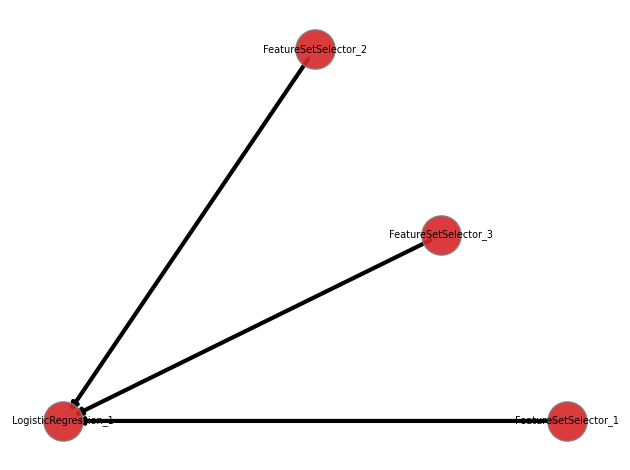

In [4]:
import tpot2
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np


est = tpot2.TPOTEstimator(population_size=40,generations=20, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            other_objective_functions=[tpot2.objectives.number_of_leaves_objective],
                            other_objective_functions_weights=[-1],
                            n_jobs=32,
                            classification=True,
                            leaf_config_dict="feature_set_selector",
                            root_config_dict=root_config_dict,
                            inner_config_dict=None,
                            subsets=None,
                            verbose=1,
                            )


scorer = sklearn.metrics.get_scorer('roc_auc_ovo')

est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))
est.fitted_pipeline_.plot()

In [5]:
# print the selected features for each FSS

#get leaves
leaves = [v for v, d in est.fitted_pipeline_.graph.out_degree() if d == 0]
for l in leaves:
    print(l, " : ", est.fitted_pipeline_.graph.nodes[l]['instance'])

FeatureSetSelector_1  :  FeatureSetSelector(name='3', sel_subset=['d'])
FeatureSetSelector_2  :  FeatureSetSelector(name='4', sel_subset=['e'])
FeatureSetSelector_3  :  FeatureSetSelector(name='5', sel_subset=['f'])


In [6]:
# print all hyperparameters
for n in est.fitted_pipeline_.graph.nodes:
    print(n, " : ", est.fitted_pipeline_.graph.nodes[n]['instance'])

LogisticRegression_1  :  LogisticRegression(C=3371.8568398103916, solver='saga')
FeatureSetSelector_1  :  FeatureSetSelector(name='3', sel_subset=['d'])
FeatureSetSelector_2  :  FeatureSetSelector(name='4', sel_subset=['e'])
FeatureSetSelector_3  :  FeatureSetSelector(name='5', sel_subset=['f'])


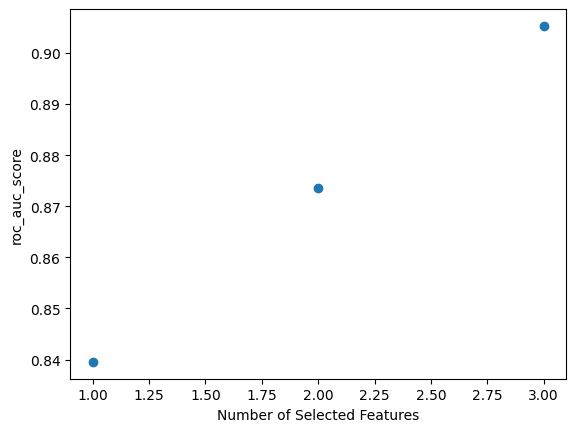

In [7]:
pareto_front = est.evaluated_individuals[est.evaluated_individuals['Pareto_Front'] == 1]

#plot the pareto front of number_of_leaves_objective vs roc_auc_score

import matplotlib.pyplot as plt
plt.scatter(pareto_front['number_of_leaves_objective'], pareto_front['roc_auc_score'])
plt.xlabel('Number of Selected Features')
plt.ylabel('roc_auc_score')
plt.show()

# Feature selection with arithmetic transformers to create features for final classifier 

here we include arithmetic operators in the inner nodes that can combine and transform the selected features. 

We now use the number of nodes objective to minimize the complexity of the resulting equation. This minimized the number of selected features and the number of arithmetic operators

Generation: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


0.9307120901639344


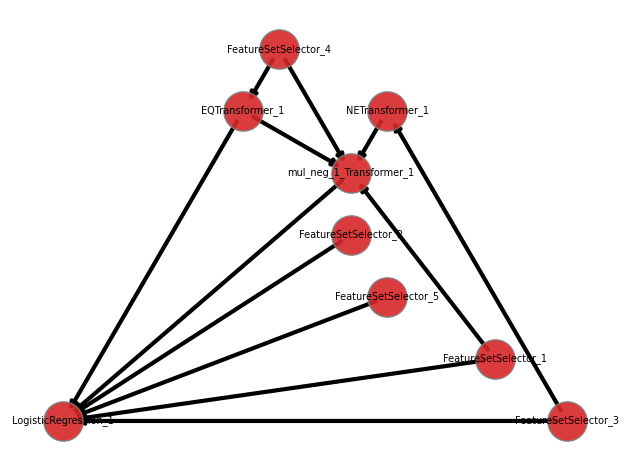

In [8]:

est = tpot2.TPOTEstimator(population_size=40,generations=20, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            other_objective_functions=[tpot2.objectives.number_of_nodes_objective],
                            other_objective_functions_weights=[-1],
                            n_jobs=32,
                            classification=True,
                            leaf_config_dict="feature_set_selector",
                            root_config_dict=root_config_dict,
                            inner_config_dict="arithmetic_transformer",
                            subsets = None,
                            verbose=1,
                            )


est.fit(X_train,y_train)
print(sklearn.metrics.get_scorer('roc_auc_ovr')(est, X_test, y_test))

est.fitted_pipeline_.plot()

In [9]:
# print the selected features for each FSS

#get leaves
leaves = [v for v, d in est.fitted_pipeline_.graph.out_degree() if d == 0]
for l in leaves:
    print(l, " : ", est.fitted_pipeline_.graph.nodes[l]['instance'])

FeatureSetSelector_1  :  FeatureSetSelector(name='5', sel_subset=['f'])
FeatureSetSelector_2  :  FeatureSetSelector(name='1', sel_subset=['b'])
FeatureSetSelector_3  :  FeatureSetSelector(name='4', sel_subset=['e'])
FeatureSetSelector_4  :  FeatureSetSelector(name='3', sel_subset=['d'])
FeatureSetSelector_5  :  FeatureSetSelector(name='0', sel_subset=['a'])


In [10]:
# print all hyperparameters
for n in est.fitted_pipeline_.graph.nodes:
    print(n, " : ", est.fitted_pipeline_.graph.nodes[n]['instance'])

LogisticRegression_1  :  LogisticRegression(C=1.3234861148420467, solver='liblinear')
FeatureSetSelector_1  :  FeatureSetSelector(name='5', sel_subset=['f'])
FeatureSetSelector_2  :  FeatureSetSelector(name='1', sel_subset=['b'])
FeatureSetSelector_3  :  FeatureSetSelector(name='4', sel_subset=['e'])
mul_neg_1_Transformer_1  :  mul_neg_1_Transformer()
EQTransformer_1  :  EQTransformer()
FeatureSetSelector_4  :  FeatureSetSelector(name='3', sel_subset=['d'])
NETransformer_1  :  NETransformer()
FeatureSetSelector_5  :  FeatureSetSelector(name='0', sel_subset=['a'])


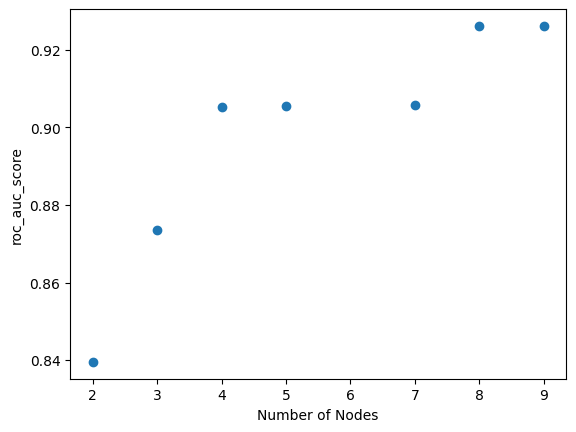

In [11]:
pareto_front = est.evaluated_individuals[est.evaluated_individuals['Pareto_Front'] == 1]

#plot the pareto front of number_of_leaves_objective vs roc_auc_score

plt.scatter(pareto_front['number_of_nodes_objective'], pareto_front['roc_auc_score'])
plt.xlabel('Number of Nodes')
plt.ylabel('roc_auc_score')
plt.show()

# Examples of FSS that select from groups of features rather than individual features

## dictionary

Generation: 100%|██████████| 20/20 [00:26<00:00,  1.31s/it]
/home/ribeirop/miniconda3/envs/tpot2env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9699667008196722


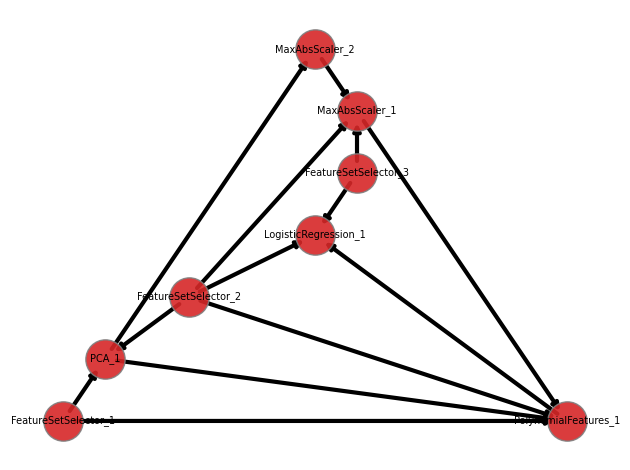

In [12]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

subsets = { "group_one" :  ['a','b','c'],
            "group_two" :  ['d','e','f'],
            "group_three" :  ['g','h','i'],
            }

est = tpot2.TPOTEstimator(population_size=40,generations=20, 
                            scorers=['roc_auc_ovr',tpot2.objectives.complexity_scorer],
                            scorers_weights=[1,-1],
                            n_jobs=32,
                            classification=True,
                            leaf_config_dict="feature_set_selector",
                            root_config_dict=root_config_dict,
                            inner_config_dict="transformers",
                            subsets = subsets,
                            verbose=1,
                            )


est.fit(X_train,y_train)
print(sklearn.metrics.get_scorer('roc_auc_ovr')(est, X_test, y_test))

est.fitted_pipeline_.plot()

In [13]:
# print the selected features for each FSS

#get leaves
leaves = [v for v, d in est.fitted_pipeline_.graph.out_degree() if d == 0]
for l in leaves:
    print(l, " : ", est.fitted_pipeline_.graph.nodes[l]['instance'])

FeatureSetSelector_1  :  FeatureSetSelector(name='group_one', sel_subset=['a', 'b', 'c'])
FeatureSetSelector_2  :  FeatureSetSelector(name='group_two', sel_subset=['d', 'e', 'f'])
FeatureSetSelector_3  :  FeatureSetSelector(name='group_three', sel_subset=['g', 'h', 'i'])


In [14]:
# print all hyperparameters
for n in est.fitted_pipeline_.graph.nodes:
    print(n, " : ", est.fitted_pipeline_.graph.nodes[n]['instance'])

LogisticRegression_1  :  LogisticRegression(C=0.06776401610163652, solver='saga')
FeatureSetSelector_1  :  FeatureSetSelector(name='group_one', sel_subset=['a', 'b', 'c'])
PolynomialFeatures_1  :  PolynomialFeatures(include_bias=False)
FeatureSetSelector_2  :  FeatureSetSelector(name='group_two', sel_subset=['d', 'e', 'f'])
MaxAbsScaler_1  :  MaxAbsScaler()
PCA_1  :  PCA(n_components=0.9574868087370769)
FeatureSetSelector_3  :  FeatureSetSelector(name='group_three', sel_subset=['g', 'h', 'i'])
MaxAbsScaler_2  :  MaxAbsScaler()


## list

Generation: 100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


0.9712474385245903


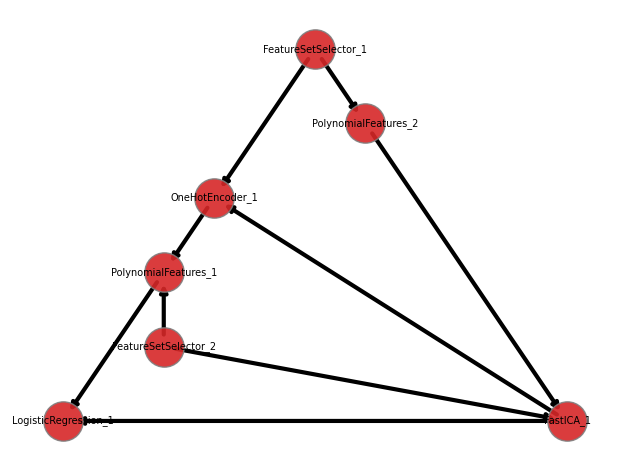

In [15]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

subsets = [['a','b','c'],['d','e','f'],['g','h','i']]

est = tpot2.TPOTEstimator(population_size=40,generations=20, 
                            scorers=['roc_auc_ovr',tpot2.objectives.complexity_scorer],
                            scorers_weights=[1,-1],
                            n_jobs=32,
                            classification=True,
                            leaf_config_dict="feature_set_selector",
                            root_config_dict=root_config_dict,
                            inner_config_dict="transformers",
                            subsets = subsets,
                            verbose=1,
                            )


est.fit(X_train,y_train)
print(sklearn.metrics.get_scorer('roc_auc_ovr')(est, X_test, y_test))

est.fitted_pipeline_.plot()

In [16]:
# print the selected features for each FSS

#get leaves
leaves = [v for v, d in est.fitted_pipeline_.graph.out_degree() if d == 0]
for l in leaves:
    print(l, " : ", est.fitted_pipeline_.graph.nodes[l]['instance'])

FeatureSetSelector_1  :  FeatureSetSelector(name='1', sel_subset=['d', 'e', 'f'])
FeatureSetSelector_2  :  FeatureSetSelector(name='0', sel_subset=['a', 'b', 'c'])


In [17]:
# print all hyperparameters
for n in est.fitted_pipeline_.graph.nodes:
    print(n, " : ", est.fitted_pipeline_.graph.nodes[n]['instance'])

LogisticRegression_1  :  LogisticRegression(C=0.01924346331466653)
PolynomialFeatures_1  :  PolynomialFeatures(include_bias=False)
OneHotEncoder_1  :  OneHotEncoder()
FeatureSetSelector_1  :  FeatureSetSelector(name='1', sel_subset=['d', 'e', 'f'])
FeatureSetSelector_2  :  FeatureSetSelector(name='0', sel_subset=['a', 'b', 'c'])
FastICA_1  :  FastICA(whiten='unit-variance')
PolynomialFeatures_2  :  PolynomialFeatures(include_bias=False)


## csv file

note: watch for spaces in the csv file!

Generation: 100%|██████████| 20/20 [00:46<00:00,  2.34s/it]
/home/ribeirop/miniconda3/envs/tpot2env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9678534836065574


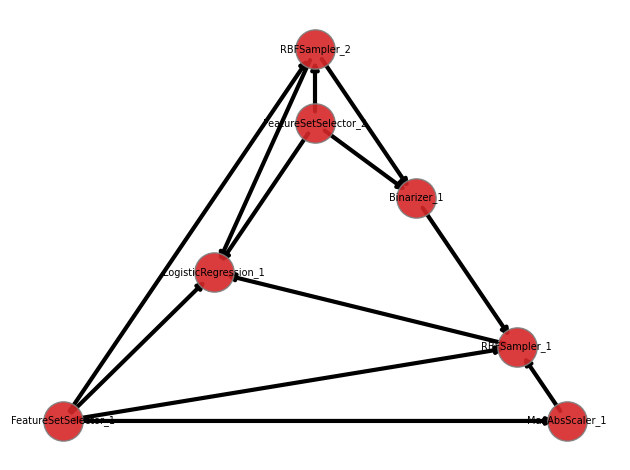

In [18]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

subsets = 'simple_fss.csv'
'''
# simple_fss.csv
one,a,b,c
two,d,e,f
three,g,h,i
'''

est = tpot2.TPOTEstimator(population_size=40,generations=20, 
                            scorers=['roc_auc_ovr',tpot2.objectives.complexity_scorer],
                            scorers_weights=[1,-1],
                            n_jobs=32,
                            classification=True,
                            leaf_config_dict="feature_set_selector",
                            root_config_dict=root_config_dict,
                            inner_config_dict="transformers",
                            subsets = subsets,
                            verbose=1,
                            )


est.fit(X_train,y_train)
print(sklearn.metrics.get_scorer('roc_auc_ovr')(est, X_test, y_test))

est.fitted_pipeline_.plot()

In [19]:
# print the selected features for each FSS

#get leaves
leaves = [v for v, d in est.fitted_pipeline_.graph.out_degree() if d == 0]
for l in leaves:
    print(l, " : ", est.fitted_pipeline_.graph.nodes[l]['instance'])

FeatureSetSelector_1  :  FeatureSetSelector(name='two', sel_subset=['d', 'e', 'f'])
FeatureSetSelector_2  :  FeatureSetSelector(name='one', sel_subset=['a', 'b', 'c'])


In [20]:
# print all hyperparameters
for n in est.fitted_pipeline_.graph.nodes:
    print(n, " : ", est.fitted_pipeline_.graph.nodes[n]['instance'])

LogisticRegression_1  :  LogisticRegression(C=90.92104183243647, solver='saga')
FeatureSetSelector_1  :  FeatureSetSelector(name='two', sel_subset=['d', 'e', 'f'])
FeatureSetSelector_2  :  FeatureSetSelector(name='one', sel_subset=['a', 'b', 'c'])
RBFSampler_1  :  RBFSampler(gamma=0.9480907031133559)
Binarizer_1  :  Binarizer(threshold=0.5204447023562712)
RBFSampler_2  :  RBFSampler(gamma=0.07182739023710172)
MaxAbsScaler_1  :  MaxAbsScaler()


note that all of the above is the same when using numpy X, but the column names are now int indeces

In [21]:
import tpot2
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

n_features = 6
X, y = sklearn.datasets.make_classification(n_samples=1000, n_features=n_features, n_informative=6, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
X = np.hstack([X, np.random.rand(X.shape[0],3)]) #add three uninformative features

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)

print(X)

[[ 0.03418023  1.85703799  1.3321493  ...  0.61740176  0.03615026
   0.73457701]
 [ 0.00655906  0.3495084  -2.86361395 ...  0.27195435  0.52330367
   0.47208072]
 [ 1.84952258 -0.98538028  0.60941956 ...  0.14054112  0.77081219
   0.17160637]
 ...
 [ 0.02282946  0.55489649 -2.89758703 ...  0.04122268  0.66234341
   0.76367281]
 [-1.34268913  2.73488335 -1.82542106 ...  0.59224411  0.94857147
   0.20810423]
 [-0.46791145  2.53228934 -2.08802875 ...  0.82326686  0.23363656
   0.77884819]]


Generation: 100%|██████████| 20/20 [00:44<00:00,  2.22s/it]
/home/ribeirop/miniconda3/envs/tpot2env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9830226151579218


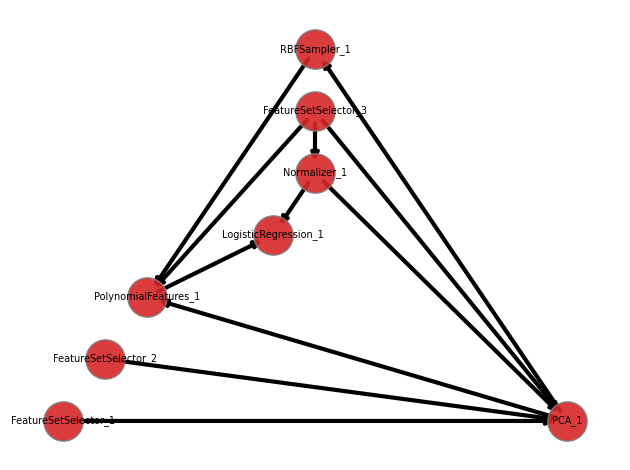

In [22]:
import tpot2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import sklearn

subsets = { "group_one" :  [0,1,2],
            "group_two" :  [3,4,5],
            "group_three" :  [6,7,8],
            }

est = tpot2.TPOTEstimator(population_size=40,generations=20, 
                            scorers=['roc_auc_ovr',tpot2.objectives.complexity_scorer],
                            scorers_weights=[1,-1],
                            n_jobs=32,
                            classification=True,
                            leaf_config_dict="feature_set_selector",
                            root_config_dict=root_config_dict,
                            inner_config_dict="transformers",
                            subsets = subsets,
                            verbose=1,
                            )


est.fit(X_train,y_train)
print(sklearn.metrics.get_scorer('roc_auc_ovr')(est, X_test, y_test))

est.fitted_pipeline_.plot()

In [23]:
# print the selected features for each FSS

#get leaves
leaves = [v for v, d in est.fitted_pipeline_.graph.out_degree() if d == 0]
for l in leaves:
    print(l, " : ", est.fitted_pipeline_.graph.nodes[l]['instance'])

FeatureSetSelector_1  :  FeatureSetSelector(name='group_one', sel_subset=[0, 1, 2])
FeatureSetSelector_2  :  FeatureSetSelector(name='group_two', sel_subset=[3, 4, 5])
FeatureSetSelector_3  :  FeatureSetSelector(name='group_three', sel_subset=[6, 7, 8])


In [24]:
# print all hyperparameters
for n in est.fitted_pipeline_.graph.nodes:
    print(n, " : ", est.fitted_pipeline_.graph.nodes[n]['instance'])

LogisticRegression_1  :  LogisticRegression(C=0.13013559430004598, solver='sag')
FeatureSetSelector_1  :  FeatureSetSelector(name='group_one', sel_subset=[0, 1, 2])
PCA_1  :  PCA(n_components=0.9988096714708292)
PolynomialFeatures_1  :  PolynomialFeatures(include_bias=False)
FeatureSetSelector_2  :  FeatureSetSelector(name='group_two', sel_subset=[3, 4, 5])
FeatureSetSelector_3  :  FeatureSetSelector(name='group_three', sel_subset=[6, 7, 8])
Normalizer_1  :  Normalizer(norm='max')
RBFSampler_1  :  RBFSampler(gamma=0.17772815448977386)
